# TH2 Poly Europe

This notebook illustrates how to create a histogram with polygonal bins (`TH2Poly`), fill it and draw it. The initial data are stored in `TMultiGraphs` and they represent the surface of some european countries.

The histogram filling is done according to a *Mercator* projection, therefore the bin content should be proportional to the real surface of the countries.

The initial data have been downloaded from http://www.maproom.psu.edu/dcw/. This database was developed in 1991/1992 and national boundaries reflect political reality as of that time.

The program is shooting `npoints` randomly over the Europe area. The number of points inside the countries should be proportional to the country surface. The estimated surface is compared to the surfaces taken from wikipedia.

---

Variables' initialization:
- Number of points.
- Latitude and longitude.

In [1]:
%jsroot on

In [2]:
auto npoints = 100000;

auto lon1 = -25.;
auto lon2 =  35.;
auto lat1 =  34.;
auto lat2 =  72.;
auto R    = (lat2-lat1)/(lon2-lon1);

Initialize global style in order to place the stats box.

In [3]:
gStyle->SetStatX(0.28);
gStyle->SetStatY(0.45);
gStyle->SetStatW(0.15);

Create canvas used to draw `TH2Poly` (the map).

In [4]:
auto W = 1000;
auto H = R*W;

TCanvas ce("ce","ce",0,0,W,H);
ce.SetGrid();

Real surfaces taken from Wikipedia.
See http://en.wikipedia.org/wiki/Area_and_population_of_European_countries

In [5]:
const int nx = 36;
const char *countries[nx] = {
    "france",     "spain",  "sweden",  "germany",       "finland",
    "norway",     "poland", "italy",   "yugoslavia",    "united_kingdom",
    "romania",    "belarus","greece",  "czechoslovakia","bulgaria",
    "iceland",    "hungary","portugal","austria",       "ireland",
    "lithuania",  "latvia", "estonia", "denmark",       "netherlands",
    "switzerland","moldova","belgium", "albania",       "cyprus",
    "luxembourg", "andorra","malta",   "liechtenstein", "san_marino",
    "monaco"
};
Float_t surfaces[nx] = {
    547030,     505580,   449964,   357021,     338145,
    324220,     312685,   301230,   255438,     244820,
    237500,     207600,   131940,   127711,     110910,
    103000,     93030,    89242,    83870,      70280,
    65200,      64589,    45226,    43094,      41526,
    41290,      33843,    30528,    28748,      9250,
    2586,       468,      316,      160,        61,
    2
};

Create histogram with surfaces of countries.

In [6]:
TH1F h("h","Countries surfaces (in km^{2})",3,0,3);
for (int i=0; i<nx; i++)
    h.Fill(countries[i], surfaces[i]);
h.LabelsDeflate();

Get remote file.

In [7]:
TFile::SetCacheFileDir(".");
auto fileUrl = "http://root.cern.ch/files/europe.root";
auto f = TFile::Open(fileUrl,"cacheread");
if (!f) cout << "Error: Cannot access remote file " << fileUrl << endl;

Info in <TFile::OpenFromCache>: using local cache copy of http://root.cern.ch/files/europe.root [./files/europe.root]


Create the map and fill it. See the documentation of [TKey](https://root.cern.ch/root/htmldoc/TKey.html) for more information about this loop.

In [8]:
TH2Poly p("Europe","Europe (bin contents are normalized to the surfaces in km^{2})",lon1,lon2,lat1,lat2);
p.GetXaxis()->SetNdivisions(520);
p.GetXaxis()->SetTitle("longitude");
p.GetYaxis()->SetTitle("latitude");
p.SetContour(100);

for (auto&& keyAsTObj : *gDirectory->GetListOfKeys()){
    auto key = (TKey*) keyAsTObj;
    auto obj = key->ReadObj();
    if (obj->InheritsFrom("TMultiGraph")) {
        auto mg = (TMultiGraph*)obj;
        p.AddBin(mg);
    }
}

Do the partitioning of the map.

In [9]:
auto partBenchmarkName = "Partitioning";
gBenchmark->Start(partBenchmarkName);
p.ChangePartition(100,100);
gBenchmark->Show(partBenchmarkName);

Partitioning: Real Time =   2.31 seconds Cpu Time =   2.31 seconds


Fill `TH2Poly` according to a Mercator projection.

In [10]:
Double_t longitude, latitude, x, y;
const Double_t pi4 = TMath::Pi()/4., alpha = TMath::Pi()/360.;

TRandom3 r;
auto fillBenchmarkName = "Filling";
gBenchmark->Start(fillBenchmarkName);

for (int i=0; i<npoints; i++) {
    longitude = r.Uniform(lon1,lon2);
    latitude  = r.Uniform(lat1,lat2);
    x         = longitude;
    y         = 38*TMath::Log(TMath::Tan(pi4+alpha*latitude));
    p.Fill(x,y);
}

gBenchmark->Show(fillBenchmarkName);

Int_t nbins = p.GetNumberOfBins();
Double_t maximum = p.GetMaximum();

Filling   : Real Time =   1.37 seconds Cpu Time =   1.38 seconds


Fill a histogram with the surfaces computed from `TH2Poly`.

In [11]:
auto h2 = (TH1F *)h.Clone("h2");
h2->Reset();
for (int j=0; j<nx; j++) {
    for (int i=0; i<nbins; i++) {
        if (strstr(countries[j],p.GetBinName(i+1))) {
            h2->Fill(countries[j],p.GetBinContent(i+1));
            h2->SetBinError(j, p.GetBinError(i+1));
        }
    }
}

Normalize the `TH2Poly` bin contents to the real surfaces.

In [12]:
Double_t scale = surfaces[0]/maximum;
for (int i=0; i<nbins; i++)
    p.SetBinContent(i+1, scale*p.GetBinContent(i+1));

Draw the canvas with the map.

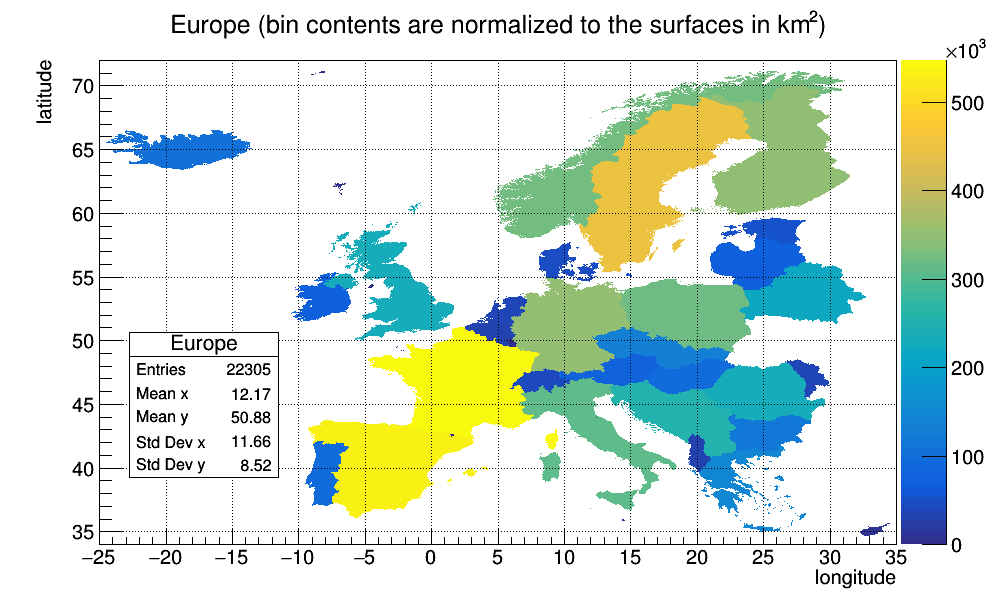

In [13]:
gStyle->SetOptStat(1111);

p.Draw("COLZ");
ce.Draw();

Set up another canvas for `h` and `h2` and draw it.

In [14]:
TCanvas c1("c1", "c1",W+10,0,W-20,H);
c1.SetRightMargin(0.047);

scale = h.GetMaximum()/h2->GetMaximum();

h.SetStats(0);
h.SetLineColor(kRed-3);
h.SetLineWidth(2);
h.SetMarkerStyle(20);
h.SetMarkerColor(kBlue);
h.SetMarkerSize(0.8);
h.Draw("LP");
h.GetXaxis()->SetLabelFont(42);
h.GetXaxis()->SetLabelSize(0.03);
h.GetYaxis()->SetLabelFont(42);

h2->Scale(scale);
Double_t scale2 = TMath::Sqrt(scale);
for (i=0; i<nx; i++)
    h2->SetBinError(i+1, scale2*h2->GetBinError(i+1));
h2->Draw("E SAME");
h2->SetMarkerStyle(20);
h2->SetMarkerSize(0.8);

TLegend leg(0.5,0.67,0.92,0.8,nullptr,"NDC");
leg.SetTextFont(42);
leg.SetTextSize(0.025);
leg.AddEntry(&h,"Real countries surfaces from Wikipedia (in km^{2})","lp");
leg.AddEntry(h2,"Countries surfaces from TH2Poly (with errors)","lp");
leg.Draw();

c1.Draw();

Print the surface estimation error.

In [15]:
auto wikiSum = h.Integral();
auto polySum = h2->Integral();
auto error = TMath::Abs(wikiSum-polySum)/wikiSum;
cout << "THPoly Europe surface estimation error wrt wikipedia = " << 100*error << " % when using " << npoints << " points" << endl;

THPoly Europe surface estimation error wrt wikipedia = 1.67678 % when using 100000 points
